# Max-Cut問題

このセクションでは、`JijModeling`と`Qamomile`ライブラリを使用して、QAOAによるMax-Cut問題の解法を紹介します。

まず、使用する主要なライブラリをインストールし、インポートしましょう。

In [1]:
# !pip install qamomile[qiskit, quri_parts]

In [2]:
from typing import List, Tuple

from IPython.display import display, Latex
import jijmodeling as jm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ommx.v1
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

import qamomile.core as qm
from qamomile.core.circuit.drawer import plot_quantum_circuit
import qamomile.qiskit as qm_qk

## Max-Cut問題とは

Max-Cut問題とは、グラフのノードを2つのグループに分割し、**カットされる辺の数（または辺に重みがある場合はカットされる辺の重みの合計）** を最大化する問題です。この問題は、ネットワークの分割や画像処理（セグメンテーション）など、さまざまな応用があります。


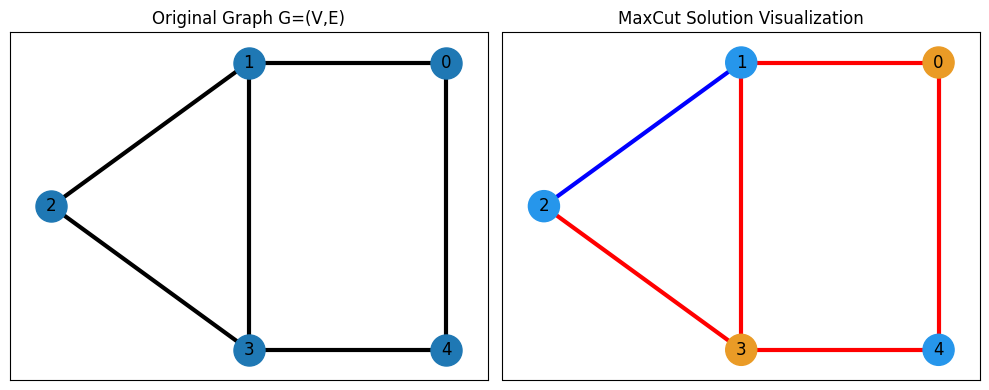

In [3]:
G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}

cut_solution = {(1,): 1.0, (2,): 1.0, (4,): 1.0}
edge_colors = []


def get_edge_colors(
    graph, cut_solution, in_cut_color="r", not_in_cut_color="b"
) -> Tuple[List[str], List[str]]:
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in G.nodes()]
    return edge_colors, node_colors


edge_colors, node_colors = get_edge_colors(G, cut_solution)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].set_title("Original Graph G=(V,E)")
nx.draw_networkx(G, pos, ax=axes[0], node_size=500, width=3, with_labels=True)
axes[1].set_title("MaxCut Solution Visualization")
nx.draw_networkx(
    G,
    pos,
    ax=axes[1],
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)

plt.tight_layout()
plt.show()

## 数理モデルの構築

Max-Cut問題は、以下の式で定式化できます：

$$
  \max \quad \frac{1}{2} \sum_{(i,j) \in E} (1 - s_i s_j)  
$$

この式は、Ising変数 $ s \in \{ +1, -1 \} $ を用いて表現されています。ここでは、`JijModeling`のバイナリ変数 $ x \in \{ 0, 1 \} $ を用いて定式化したいと考えます。そのために、Ising変数とバイナリ変数の間で以下のような変換を行います：

$$
    x_i = \frac{1 + s_i}{2} \quad \Rightarrow \quad s_i = 2x_i - 1
$$


In [4]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem


problem = Maxcut_problem()
problem

## インスタンスデータの準備

次に、以下のグラフに対してMax-Cut問題を解いていきます。ここで解く特定の問題に対応するデータは、インスタンスデータ（instance data）と呼ばれます。


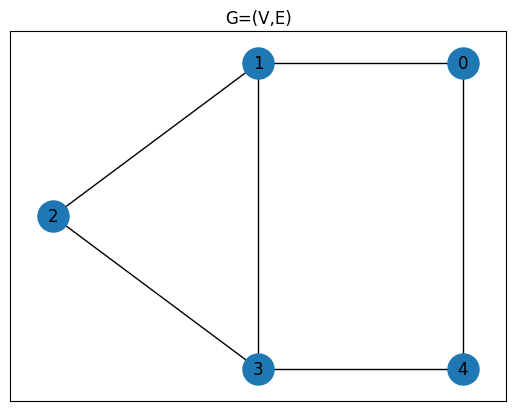

In [5]:
G = nx.Graph()
num_nodes = 5
edges = [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)

weight_matrix = nx.to_numpy_array(G, nodelist=list(range(num_nodes)))

plt.title("G=(V,E)")
plt.plot(figsize=(5, 4))

nx.draw_networkx(G, pos, node_size=500)

In [6]:
V = num_nodes
E = edges

data = {"V": V, "E": E}

data

{'V': 5, 'E': [(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)]}

## コンパイル済みインスタンスの作成

先ほど準備した定式化とインスタンスデータを用いて、`JijModeling.Interpreter`と`ommx.Instance`を使ってコンパイルを行います。この処理により、インスタンスデータが代入された問題の中間表現が得られます。

In [7]:
interpreter = jm.Interpreter(data)
compiled_model = interpreter.eval_problem(problem)

## コンパイル済みインスタンスからQAOA回路とハミルトニアンへの変換

コンパイル済みインスタンスから、QAOA回路とハミルトニアンを生成します。これらの生成には`qm.qaoa.QAOAConverter`を使用します。

このクラスのインスタンスを作成し、`ising_encode`を用いることで、内部的にコンパイル済みインスタンスからIsingハミルトニアンを生成できます。QUBOへの変換時に必要となるパラメータもここで設定できます。設定しない場合は、デフォルト値が使用されます。

Isingハミルトニアンが生成された後は、それぞれQAOAの量子回路とハミルトニアンを生成できます。これらは `get_qaoa_ansatz`メソッドと`get_cost_hamiltonian`メソッドを使って取得します。ここでは、QAOAのレイヤー数 $p$ は $5$ に固定されています。


In [8]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_model)

qaoa_converter.ising_encode()

qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()

p = 5

qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

## QAOA回路の可視化

Qamomileには、量子回路を可視化するためのメソッドが用意されています。`plot_quantum_circuit`関数を使うことで、QAOAの量子回路を視覚的に確認することができます。

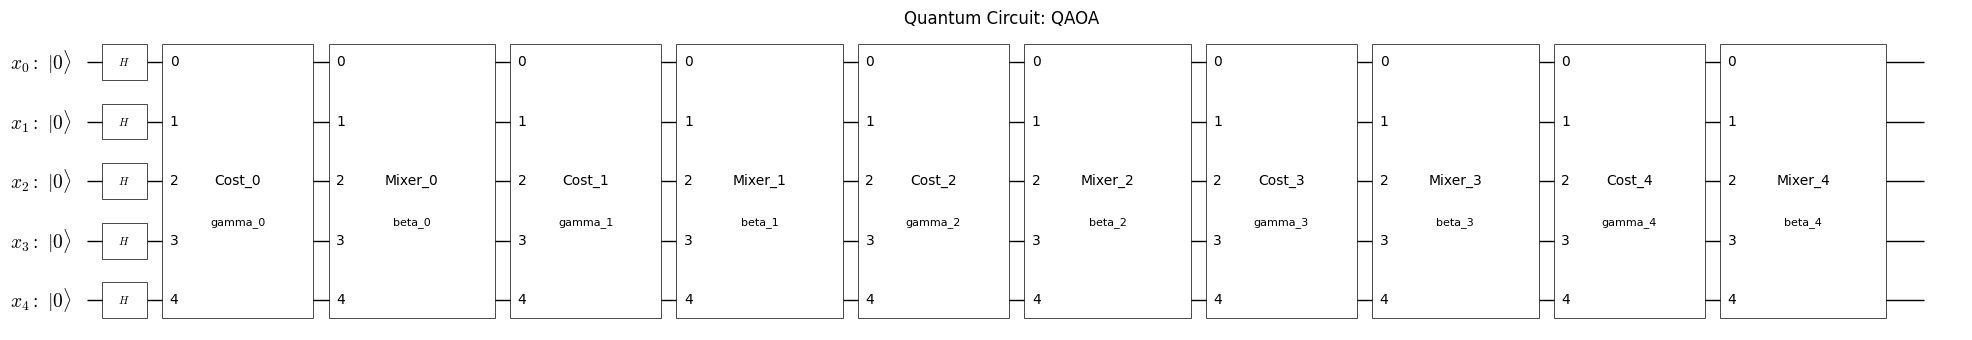

In [9]:
plot_quantum_circuit(qaoa_circuit)

## 取得したQAOA回路とハミルトニアンをQiskit向けに変換

ここでは、`qamomile.qiskit.QiskitTranspiler`のコンバータを用いて、Qiskit用のQAOA回路とハミルトニアンを生成します。`QiskitTranspiler.transpile_circuit`メソッドと `QiskitTranspiler.transpile_hamiltonian`メソッドを利用することで、QAOA回路とハミルトニアンをQiskitに適した形式へと変換できます。これにより、Qiskitの量子コンピューティングフレームワークを活用して実行および解析が可能となります。


In [10]:
qk_transpiler = qm_qk.QiskitTranspiler()

# QAOA 回路を Qiskit 用に変換する
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)

# QAOA ハミルトニアンを Qiskit 用に変換する
qk_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIZZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'IZZII', 'ZZIII', 'IIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -3. +0.j])

## QAOAの実行

QAOAを実行してパラメータの最適化を行います。ここでは、最適化手法としてCOBYLAを使用します。


In [11]:
cost_history = []
# コスト推定関数
estimator = qk_pr.StatevectorEstimator()


def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"Error during cost estimation: {e}")
        return np.inf


# 初期パラメータの作成
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)

# QAOA最適化の実行
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000, "tol": 1e-2},
)
print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -4.79763348999377
       x: [-5.698e-01  4.038e-02 -3.595e-01 -6.050e-01 -9.792e-01
            4.794e-01  6.737e-02  9.649e-01  3.063e-01 -2.216e-01]
    nfev: 296
   maxcv: 0.0


## 結果の可視化

最適化を繰り返すことで、エネルギーが減少し収束していく様子を観察できます。


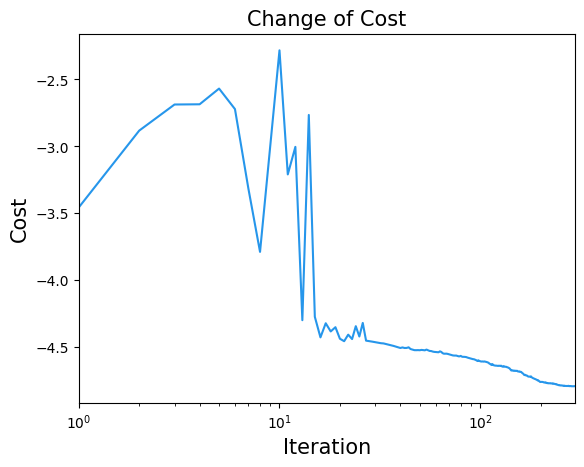

In [12]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

さて、次に最適化されたパラメータを用いて、Qiskitの`StatevectorSampler`を実行してみましょう。

In [13]:
# 最適化された QAOA 回路の実行
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

## 結果の評価

先ほど取得したジョブのカウント情報から、`qaoa_converter.decode`を用いてsamplesetに変換することができます。samplesetでは、実行可能な解（feasible solutions）のみを選択することができ、目的関数の値の分布を調べることができます。


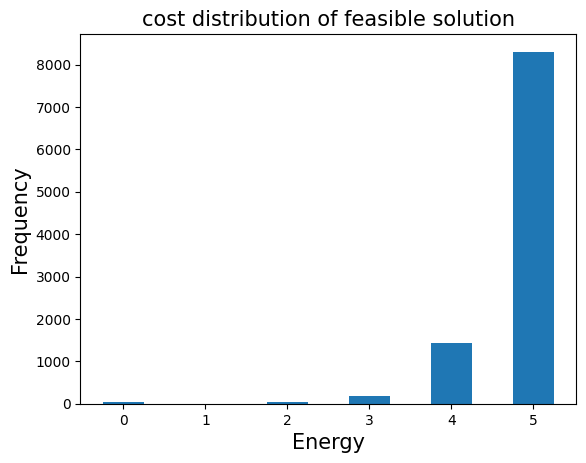

In [14]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result.data["meas"])
plot_data = {}
energies = []
frequencies = []
# Create a dictionary to group energies and count their frequencies
from collections import defaultdict
energy_freq = defaultdict(int)

for sample_id in sampleset.sample_ids:
    sample = sampleset.get(sample_id)
    energy_freq[sample.objective] += 1

energies = list(energy_freq.keys())
frequencies = list(energy_freq.values())

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()

## 解のプロット

得られた結果から、目的関数の値を最小化する解を一つ選び、それをプロットします。  
（赤色の線はMax-Cutにおいてカットされた辺を表しています。）


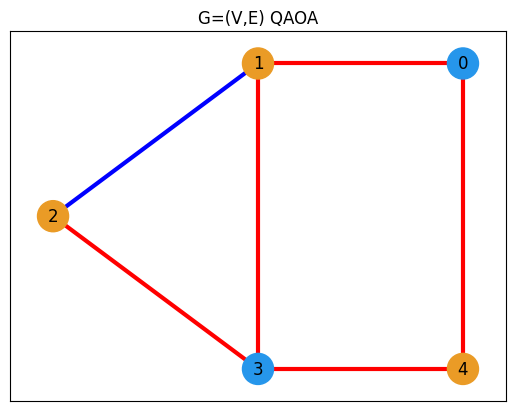

In [15]:
best_values = sampleset.best_feasible_unrelaxed.extract_decision_variables("x")
edge_colors, node_colors = get_edge_colors(G, best_values)

plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(
    G,
    pos,
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)